In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:90%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:11pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:10pt;padding:5px;}
table.dataframe{font-size:10px;}
</style>
"""))

<b><font size="6" color="red">Ch.8 Transformers - 영화평 분석</font><b>
- IMDb 사이트의 영화 감상평 5만 개: Train/Test 데이터 
- 타깃변수: 부정(0)/긍정(1)

# ✅ 1. 패키지 import

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# ✅ 2. 하이퍼파라미터 설정
- 하이퍼파라미터를 바꾸면 모델의 정확도나 속도에 차이

In [3]:
MY_WORDS = 20000 # imdb 데이터 안의 단어 수
MY_LENGTH = 200 # 독립변수 차원(영화평 평균 길이 정도로)
MY_EMBED = 32 # Embedding 결과 차원
MY_HIDDEN = 64 # LSTM의 units수
MY_EPOCH = 15 # fit 학습 반복 수
MY_BATCH = 200 # 배치사이즈(fit할 때, 매번 가져오는 데이터 수)

# # 불용어 설정(빈도수가 높은 상위 단어는 대개 the, a, is, have ...)
# SKIP_TOP = 30

# ✅ 3. 데이터 불러오기

In [5]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MY_WORDS, # 1~MY_WORDS까지 숫자로 가져오고, 나머지는 2로 분류
                                                     )

# ✅ 4. 문자 단어 → 정수

In [6]:
word_to_id = imdb.get_word_index() #빈도가 높은 단어는 앞으로

# 정수 → 문자 단어
id_to_word = {} # 정수(id) : 문자단어
for key, value in  word_to_id.items():
    id_to_word[value] = key

# SKIP_TOP 값을 고민하기 위해 최빈 단어 확인 - 
print([id_to_word[i] for i in range(1, 41)])

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all', 'at', 'by', 'an', 'they', 'who', 'so', 'from', 'like', 'her', 'or', 'just']


In [7]:
msg = "What a wonderful moviee" # 없는 단어 어떻게 하나 보자. 일부러 오타
msg = msg.lower().split()
print(msg)
# 1: 리뷰의 시작을 알리는 숫자
# 2: MY_WORDS 안에 들어가지 않는 단어
# 3: padding 처리
data = [1] + [word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용: ', msg)
print('encoded된 내용(data) - SKIP_TOP 처리 안 할 경우: ', data)
print('encoded된 내용(data) - SKIP_TOP 처리할 경우: ', data)
print('data 추정: ', ' '.join([id_to_word.get(d-3, '???') for d in data]))

['what', 'a', 'wonderful', 'moviee']
원 후기 내용:  ['what', 'a', 'wonderful', 'moviee']
encoded된 내용(data) - SKIP_TOP 처리 안 할 경우:  [1, 51, 6, 389, 2]
encoded된 내용(data) - SKIP_TOP 처리할 경우:  [1, 51, 6, 389, 2]
data 추정:  ??? what a wonderful ???


# ✅ 5. 숫자 영화평 → 자연어 영화평 함수

In [8]:
def decoding(review_nums):
    decoded = [] #숫자를 단어로 해석한 내용 append 예정
    for num in review_nums:
        word = id_to_word.get(num - 3, '???')
        decoded.append(word)
    print(' '.join(decoded))

In [ ]:
print(X_test[0])

In [ ]:
decoding(X_train[0]), y_train[0]

In [ ]:
decoding(X_test[0]), y_test[0]

In [ ]:
# X_train 후기 중 가장 단어수 많은 리뷰, 가장 단어수 적은 리뷰
max([len(x) for x in X_train]), min([len(x) for x in X_train])

In [ ]:
# 영화평 길이 평균
np.array([len(x) for x in X_train]).mean()

# 6. 영화평 학습용 데이터 처음 10개의 길이 출력 함수

In [ ]:
def show_length():
    print('첫 10개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이: {len(X_train[i])}')
    print([len(x) for x in X_train[:10]])
show_length()

In [ ]:
print('pad_sequence 작업 전')
show_length()

In [ ]:
# X_train 후기 중 가장 긴 단어수, 가장 짧은 단어수
max ([len(x) for x in X_train]), min([len(x) for x in X_train])

# ✅ 7. 모든 영화평의 길이를 동일하게 (MY_LENGTH만큼)

In [11]:
X_train = pad_sequences(X_train, 
                        maxlen=MY_LENGTH, 
#                         truncating='pre', # 지정한 단어수(80) 이상일 경우 어디를 자를지
                        truncating='post',
                        padding='pre',
#                         padding='post' # 짧을 경우 앞/뒤에 zero를 붙임
                       ) 
X_test = pad_sequences(X_test, 
                        maxlen=MY_LENGTH, 
#                         truncating='pre', # 지정한 단어수(80) 이상일 경우 어디를 자를지
                        truncating='post',
                        padding='pre',
#                         padding='post' # 짧을 경우 앞/뒤에 zero를 붙임                       
                      )

# 8. 최종 데이터 shape 확인

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 200), (25000,), (25000, 200), (25000,))

In [ ]:
decoding(X_train[0])

# 9-1. 모델 생성 및 구현 - LSTM

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS, #1000
                    output_dim=MY_EMBED, #32
                    input_length=MY_LENGTH, #80
                   ))
model.add(LSTM(units=MY_HIDDEN, #64
               dropout=0.6, # 0.1~0.5 / 각 스텝마다 LSTM셀로 들어가는 연결 30%를 0으로
               recurrent_dropout=0.4 # 0.1~0.3 이전 LSTM에서 다음 LSTM 셀로 가는 연결 20%를 0으로
               # input_shape=(MY_LENGTH, MY_EMBED), 
               # kernel_initializer='he_normal' #입력가중치 초기화
               # recurrent_initializer='orthogonal' #순환가중치 초기화
              ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

# ✅ 9-2. Transformers 인코딩부분 모델 구현

In [13]:
from tensorflow import range
from tensorflow.keras.layers import Input, Dropout, MultiHeadAttention, add, BatchNormalization, GlobalAvgPool1D, Dense
from tensorflow.keras.models import Model, Sequential

# 입력층, 임베딩층
INPUTS = Input(shape=MY_LENGTH) #독립변수
INPUT_EMBEDDING = Embedding(input_dim=MY_WORDS,
                            output_dim=MY_EMBED
                           )(INPUTS)

# Positional Encoding
POSITIONS = range(start=0, limit=MY_LENGTH)
POS_ENCODING = Embedding(input_dim=MY_WORDS,
                         output_dim=MY_EMBED
                        )(POSITIONS)
POS_ENC_OUTPUT = POS_ENCODING + INPUT_EMBEDDING

# Multi-head Attention
ATTENTION_OUTPUT = MultiHeadAttention(num_heads=3, 
                                      key_dim=MY_EMBED)(POS_ENC_OUTPUT, POS_ENC_OUTPUT)
X = add([POS_ENC_OUTPUT, ATTENTION_OUTPUT])
X = BatchNormalization()(X)

# FFN (Feed Forward Network)
FFN = Sequential([
    Dense(MY_HIDDEN, activation='relu'),
    Dense(MY_EMBED, activation='relu')
])(X)
X = add([FFN, X])
X = BatchNormalization()(X)

# 하나의 벡터로 하여 Dense에 보냄
X = GlobalAvgPool1D()(X)
X = Dropout(0.1)(X)
X = Dense(units=MY_HIDDEN, activation='relu')(X)
X = Dropout(0.1)(X)
OUTPUTS = Dense(units=2, # 부정그룹/긍정그룹 (다중분류방식)
                activation='softmax')(X)

model = Model(inputs=INPUTS, outputs=OUTPUTS)

# ✅ 10. 학습환경 설정 및 학습하기

In [14]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
start = time() # 70.1.1 유닉스 타임
earlyStopping = EarlyStopping(patience=5)
hist = model.fit(X_train, y_train, 
                 epochs=MY_EPOCH, 
                 batch_size=MY_BATCH, 
                 validation_split=0.2, 
                 verbose=1,
                callbacks=[earlyStopping])
end = time()
print('총 fit 시간: {:.5f}'.format(end-start))

Epoch 1/15
100/100 [==============================] - 37s 368ms/step - loss: 0.4648 - acc: 0.7756 - val_loss: 0.5641 - val_acc: 0.8288
Epoch 2/15
100/100 [==============================] - 39s 390ms/step - loss: 0.2094 - acc: 0.9205 - val_loss: 0.5070 - val_acc: 0.7946
Epoch 3/15
100/100 [==============================] - 39s 390ms/step - loss: 0.1215 - acc: 0.9566 - val_loss: 0.3937 - val_acc: 0.8306
Epoch 4/15
100/100 [==============================] - 39s 389ms/step - loss: 0.0818 - acc: 0.9703 - val_loss: 0.3362 - val_acc: 0.8612
Epoch 5/15
100/100 [==============================] - 39s 390ms/step - loss: 0.0526 - acc: 0.9812 - val_loss: 0.5039 - val_acc: 0.8370
Epoch 6/15
100/100 [==============================] - 41s 408ms/step - loss: 0.0432 - acc: 0.9843 - val_loss: 0.6124 - val_acc: 0.8314
Epoch 7/15
100/100 [==============================] - 42s 421ms/step - loss: 0.0445 - acc: 0.9833 - val_loss: 0.6915 - val_acc: 0.8536
Epoch 8/15
100/100 [==============================] - 4

# 11. 모델 평가

In [15]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

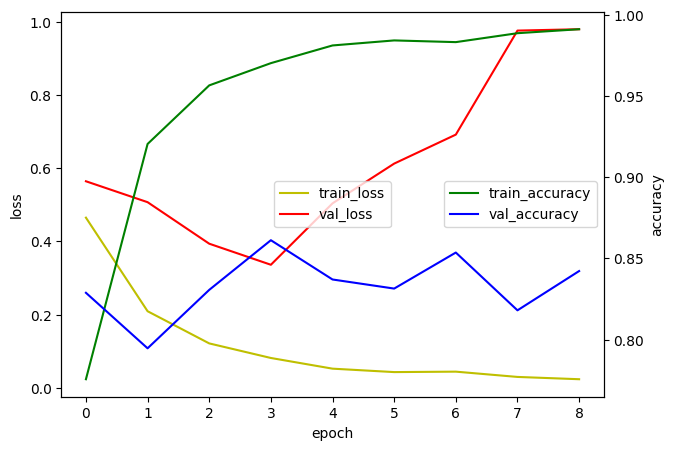

In [16]:
# 시각화 1
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(7,5))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [17]:
# 테스트 데이터로 평가 1
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('test의 데이터 정확도: ', acc)

test의 데이터 정확도:  0.8138800263404846


In [18]:
# 모델 저장
model.save('imdb_v2.10_transformer.h5')

In [29]:
# 혼동행렬(교차표, 평가성능지표)
# y_test: 실제값
pred = model.predict(X_test)
y_hat = (pred>0.5).astype(int).argmax(axis=-1)
y_hat

782/782 [==============================] - 24s 30ms/step


array([0, 1, 1, ..., 0, 0, 1], dtype=int64)

In [30]:
# 실제값(1d)과 예측값(2d)의 차원이 같지 않아도 됨
confusion_matrix(y_test, y_hat)

array([[ 9702,  2798],
       [ 1855, 10645]], dtype=int64)

In [31]:
# 실제값과 예측값의 차원이 모두 1차원이어야 함
pd.crosstab(y_test, y_hat.reshape(-1), rownames=['실제값'], colnames=['예측값']) 

예측값,0,1
실제값,,
0,9702,2798
1,1855,10645


In [32]:
# accuracy, precision, recall, f1_score
print('acc:', acc)
print('precision:', precision_score(y_test, y_hat))
print('recall:', recall_score(y_test, y_hat))
print('f1_score:', f1_score(y_test, y_hat))

acc: 0.8138800263404846
precision: 0.7918619355798557
recall: 0.8516
f1_score: 0.8206452607639827


# 12. 모델 사용하기

In [33]:
import re
review="""
Wicked for Good promised a continuation of the beloved story, yet the resulting film felt curiously deflated, struggling to recapture the potent magic of its predecessor. While the visual spectacle is undeniable—the costumes and set design are, at times, breathtaking—they often serve as a glittering distraction from a narrative that meanders without real purpose.
The core issue lies in the pacing and character arcs. The emotional stakes established so clearly before seem to have been exchanged for superficial grand gestures. Performances, while sincere, appear constrained by a script that leans too heavily on exposition and callbacks, rather than forging genuinely new ground. It’s particularly disappointing to see the complexity of the central friendship reduced to predictable emotional beats. Instead of soaring to new heights, the film remains grounded, offering competent but ultimately uninspired interpretations of themes we’ve seen explored far more compellingly.
The music, an essential component of this universe, lacks the soaring, memorable quality one anticipates. Several numbers feel oddly generic, failing to stick with you long after the credits roll. Wicked for Good is a perfectly adequate viewing experience, a film that checks all the necessary boxes without ever truly lighting up the screen. It is a production that respects the original material, perhaps too much, resulting in something safe, glossy, and, regrettably, a touch hollow. For a story about defying gravity, this sequel never quite manages to take flight.
""".lower()
review = re.sub('^a-zA-Z0-9\s', ' ', review)
review = review.split()
encoded = [1] + [word_to_id.get(r, -1) + 3 for r in review]
print(encoded)

[1, 3799, 18, 52, 4407, 6, 11034, 7, 4, 2762, 2, 246, 4, 5000, 22, 421, 7338, 2, 2519, 8, 11119, 4, 8651, 1236, 7, 94, 2, 137, 4, 1114, 6535, 9, 2, 1352, 5, 270, 1592, 2, 33, 2, 2, 400, 2895, 17, 6, 33780, 6797, 39, 6, 1321, 15, 11726, 209, 147, 2, 4, 2026, 1834, 1838, 11, 4, 1794, 5, 109, 2, 4, 921, 9926, 2921, 38, 695, 159, 306, 8, 28, 77, 16593, 18, 3903, 1758, 2, 2, 137, 2, 977, 22202, 34, 6, 229, 15, 15040, 99, 2699, 23, 5302, 5, 2, 247, 74, 21978, 2070, 162, 2, 21383, 572, 1332, 8, 67, 4, 4640, 7, 4, 1375, 1862, 3747, 8, 727, 921, 2, 305, 7, 18743, 8, 162, 2, 4, 22, 1287, 2, 3991, 3275, 21, 1116, 3658, 7543, 7, 1326, 2, 110, 4087, 230, 53, 2, 4, 2, 35, 2963, 10880, 7, 14, 2, 1503, 4, 2, 906, 489, 31, 2, 450, 1396, 235, 2990, 2, 3718, 8, 1231, 19, 25, 196, 103, 4, 898, 2, 3799, 18, 52, 9, 6, 950, 3927, 829, 2, 6, 22, 15, 10138, 32, 4, 1670, 9237, 209, 126, 371, 1524, 56, 4, 2, 12, 9, 6, 365, 15, 6851, 4, 204, 2, 382, 99, 2, 5000, 11, 142, 2, 2, 2, 2, 6, 1229, 2, 18, 6, 65, 44, 152

In [38]:
input_data = pad_sequences([encoded], 
                        maxlen=200, 
#                         truncating='pre', # 지정한 단어수(80) 이상일 경우 어디를 자를지
                        truncating='post',
                        padding='pre',
#                         padding='post' # 짧을 경우 앞/뒤에 zero를 붙임
                       )[0]
input_data, len(input_data)

(array([    1,  3799,    18,    52,  4407,     6, 11034,     7,     4,
         2762,     2,   246,     4,  5000,    22,   421,  7338,     2,
         2519,     8, 11119,     4,  8651,  1236,     7,    94,     2,
          137,     4,  1114,  6535,     9,     2,  1352,     5,   270,
         1592,     2,    33,     2,     2,   400,  2895,    17,     6,
        33780,  6797,    39,     6,  1321,    15, 11726,   209,   147,
            2,     4,  2026,  1834,  1838,    11,     4,  1794,     5,
          109,     2,     4,   921,  9926,  2921,    38,   695,   159,
          306,     8,    28,    77, 16593,    18,  3903,  1758,     2,
            2,   137,     2,   977, 22202,    34,     6,   229,    15,
        15040,    99,  2699,    23,  5302,     5,     2,   247,    74,
        21978,  2070,   162,     2, 21383,   572,  1332,     8,    67,
            4,  4640,     7,     4,  1375,  1862,  3747,     8,   727,
          921,     2,   305,     7, 18743,     8,   162,     2,     4,
      

In [39]:
model.predict(input_data)

InvalidArgumentError: Graph execution error:

Detected at node 'model/tf.__operators__.add/AddV2' defined at (most recent call last):
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\kernelbase.py", line 519, in dispatch_queue
      await self.process_one()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\kernelbase.py", line 508, in process_one
      await dispatch(*args)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\ipkernel.py", line 368, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\ipkernel.py", line 455, in do_execute
      res = shell.run_cell(
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\zmqshell.py", line 602, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Admin\AppData\Local\Temp\ipykernel_16904\3528688361.py", line 1, in <module>
      model.predict(input_data)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\layers\core\tf_op_layer.py", line 242, in _call_wrapper
      return self._call_wrapper(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\layers\core\tf_op_layer.py", line 279, in _call_wrapper
      result = self.function(*args, **kwargs)
Node: 'model/tf.__operators__.add/AddV2'
Incompatible shapes: [32,32] vs. [200,32]
	 [[{{node model/tf.__operators__.add/AddV2}}]] [Op:__inference_predict_function_29966]